# Statistical Analyses

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from analysis import MultiAnalysis, MultiRunAnalysis, MultiAnalysis2Fits
from scipy.stats import ranksums, kruskal, wilcoxon
from statsmodels.stats.proportion import proportions_ztest


data_path = "../data"
save_path = "../figs"

### Confidence Interval Tables

In [2]:
ma = MultiAnalysis(data_path, ['baseline'])
df = ma.get_confidence_intervals()

df = df.unstack(0).stack(0, future_stack=True)
df.index = df.index.swaplevel(0, 2)
df = df.sort_index()

active = df.loc[('active', ['proportion', 'IoU', 'turnover'], slice(None))]
place = df.loc[('place', ['proportion', 'IoU', 'turnover', 'remapping'], slice(None))]

In [3]:
remaps = pd.concat([active, place]).unstack(0)
remaps.index = remaps.index.map('{0[0]} ({0[1]})'.format)
print(remaps.T.droplevel(0).to_latex())

\begin{tabular}{llllll}
\toprule
 & proportion (trn) & proportion (unt) & IoU (unt) & turnover (unt) & remapping (unt) \\
\midrule
active & 0.47$\pm$0.04 & 0.56$\pm$0.06 & 0.69$\pm$0.03 & 0.38$\pm$0.06 & NaN \\
place & 0.41$\pm$0.04 & 0.33$\pm$0.06 & 0.37$\pm$0.06 & 0.80$\pm$0.08 & 0.97$\pm$0.03 \\
\bottomrule
\end{tabular}



In [4]:
coverage = df.loc['place'].loc[['coverage', 'sizes', 'scales']]
print(coverage.unstack(0).droplevel(0, axis=1).to_latex())

\begin{tabular}{llll}
\toprule
 & coverage & sizes & scales \\
\midrule
trn & 0.95$\pm$0.04 & 0.06$\pm$6.8e-03 & 0.30$\pm$0.02 \\
unt & 0.52$\pm$0.08 & 0.02$\pm$3.4e-03 & 0.13$\pm$0.03 \\
\bottomrule
\end{tabular}



### Miscellaneous Statistical Test

#### Hidden unit proportions

In [6]:
mra = MultiRunAnalysis(data_path, 'baseline')

In [7]:
trn = mra.df[mra.df.index.get_level_values(1) == 1].loc[(slice(None), slice(None), 'proportion')]
unt = mra.df[mra.df.index.get_level_values(1) != 1].loc[(slice(None), slice(None), 'proportion')]

In [8]:
ranksums(trn.place, unt.place, alternative='greater')

RanksumsResult(statistic=3.3628627914094493, pvalue=0.0003856934678807837)

In [9]:
ranksums(trn.active, unt.active, alternative='less')

RanksumsResult(statistic=-3.3968311024337874, pvalue=0.00034085514668541917)

#### Scales

In [10]:
trn = mra.df[mra.df.index.get_level_values(1) == 1].loc[(slice(None), slice(None), 'scales')].place
unt = mra.df[mra.df.index.get_level_values(1) != 1].loc[(slice(None), slice(None), 'scales')].place

In [11]:
mra.get_confidece_intervals().loc[(slice(None), 'scales'), ['place']]

,,place
trn,scales,0.25$\pm$0.03
unt,scales,0.16$\pm$0.03


In [12]:
ranksums(trn, unt)

RanksumsResult(statistic=3.3968311024337874, pvalue=0.0006817102933708383)

### Hidden Size

#### Proportions

In [13]:
mra = MultiRunAnalysis(data_path, 'hidden500')

In [14]:
df = mra.df.loc[(slice(None), slice(None), 'proportion'), :]
trn_ac = df.active.loc[(slice(None), 1, slice(None))]
unt_ac = df[df.index.get_level_values(1) != 1].active
trn_pc = df.place.loc[(slice(None), 1, slice(None))]
unt_pc = df[df.index.get_level_values(1) != 1].place

In [15]:
kruskal(trn_ac, unt_ac, trn_pc)

KruskalResult(statistic=6.4691314031180465, pvalue=0.03937730272825077)

In [16]:
wilcoxon(unt_pc, unt_ac, alternative='less')

WilcoxonResult(statistic=210.0, pvalue=0.9999557754248939)

#### Coverage

In [17]:
hiddens = [f'hidden{n}' for n in [20, 50, 200, 500]]
hiddens.insert(2, 'baseline')

ma = MultiAnalysis(data_path, hiddens)

In [18]:
var = ['coverage', 'scales', 'sizes']
units = ['place']
how = 'trn'

{v: kruskal(*data) for v, data in ma.get_data_for_statistical_test(var, units, how).items()}

{'coverage': KruskalResult(statistic=21.559069767441873, pvalue=0.0002452650268510063),
 'scales': KruskalResult(statistic=23.07692307692308, pvalue=0.00012222331995353944),
 'sizes': KruskalResult(statistic=21.74030769230771, pvalue=0.00022573999700744197)}

In [19]:
var = ['coverage', 'scales', 'sizes']
units = ['place']
how = 'unt'

{v: kruskal(*data) for v, data in ma.get_data_for_statistical_test(var, units, how).items()}

{'coverage': KruskalResult(statistic=93.9118811881188, pvalue=1.9414960931685915e-19),
 'scales': KruskalResult(statistic=91.98487128712873, pvalue=4.986168446002239e-19),
 'sizes': KruskalResult(statistic=61.22803960396044, pvalue=1.6009576809359902e-12)}

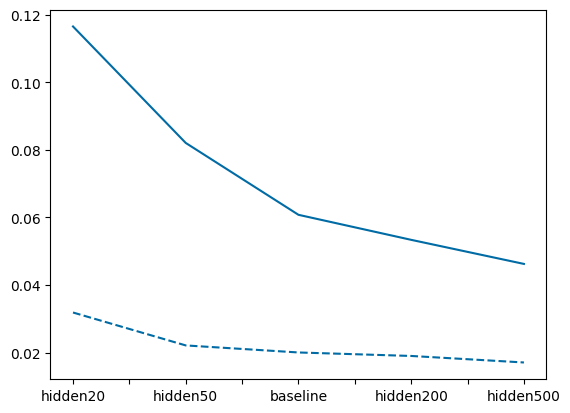

In [20]:
df = ma.coverage_stats().loc[:, 'place']
ax = df.loc[('trn', 'sizes')].T.plot()
ax.set_prop_cycle(None)
df.loc[('unt', 'sizes')].T.plot(ax=ax, linestyle='--')
plt.show()

#### Remapping

In [21]:
hiddens = [f'hidden{n}' for n in [20, 50, 200, 500]]
hiddens.insert(2, 'baseline')

ma = MultiAnalysis(data_path, hiddens)

In [22]:
var = ['remapping', 'turnover']
units = ['place']
how = 'unt'

{v: kruskal(*data) for v, data in ma.get_data_for_statistical_test(var, units, how).items()}

{'remapping': KruskalResult(statistic=9.376355204397136, pvalue=0.05235081957161648),
 'turnover': KruskalResult(statistic=15.362639529022067, pvalue=0.004005262326750263)}

In [23]:
var = ['turnover']
units = ['active']
how = 'unt'

{v: kruskal(*data) for v, data in ma.get_data_for_statistical_test(var, units, how).items()}

{'turnover': KruskalResult(statistic=83.90504007166605, pvalue=2.5896477574670777e-17)}

### L1 Regularization

In [24]:
l1s = [f'l1_{n}' for n in ['1', '05', '01', '001', '0001', '00001', '000001', '0']]
l1s.insert(4, 'baseline')

ma = MultiAnalysis(data_path, l1s)

In [25]:
var = ['proportion']
units = ['place']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how, l1s[4:])

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=2.226632144019082, pvalue=0.6941565551813774)}

In [26]:
units = ['active']

data = ma.get_data_for_statistical_test(var, units, how, l1s[4:])

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=8.455413338959048, pvalue=0.07625029589673091)}

In [27]:
var = ['remapping', 'turnover']
units = ['place']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how, l1s[4:])

{v: kruskal(*data) for v, data in data.items()}

{'remapping': KruskalResult(statistic=5.573600137409806, pvalue=0.23333532071595012),
 'turnover': KruskalResult(statistic=4.167091988308649, pvalue=0.3838644580242972)}

In [28]:
var = ['turnover']
units = ['active']

data = ma.get_data_for_statistical_test(var, units, how, l1s[4:])

{v: kruskal(*data) for v, data in data.items()}

{'turnover': KruskalResult(statistic=5.474733932398125, pvalue=0.24195933057011237)}

In [29]:
subset = [f'l1_{n}' for n in ['1', '05', '01', '001', '0001', '00001', '000001', '0']]
subset.insert(4, 'baseline')

In [30]:
var = ['proportion']
units = ['place']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how)

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=101.53237371744069, pvalue=2.0749356720936873e-18)}

In [31]:
units = ['active']

data = ma.get_data_for_statistical_test(var, units, how)

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=67.26295985413522, pvalue=1.7194976601282186e-11)}

In [32]:
var = ['remapping', 'turnover']
units = ['place']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how, subset)

{v: kruskal(*data) for v, data in data.items()}

{'remapping': KruskalResult(statistic=9.875187172112131, pvalue=0.2738957015962149),
 'turnover': KruskalResult(statistic=10.727507361883621, pvalue=0.21762210340311702)}

In [33]:
var = ['turnover']
units = ['active']

data = ma.get_data_for_statistical_test(var, units, how, subset)

{v: kruskal(*data) for v, data in data.items()}

{'turnover': KruskalResult(statistic=125.51278804510552, pvalue=2.4042969879171926e-23)}

#### Coverage

In [34]:
var = ['coverage', 'sizes', 'scales']
units = ['place']
how = 'trn'

data = ma.get_data_for_statistical_test(var, units, how)

{v: kruskal(*data) for v, data in data.items()}

{'coverage': KruskalResult(statistic=23.190513209038798, pvalue=0.003128069484182739),
 'sizes': KruskalResult(statistic=37.79246376811594, pvalue=8.222811174744198e-06),
 'scales': KruskalResult(statistic=32.13217391304349, pvalue=8.819849012361027e-05)}

In [35]:
var = ['coverage', 'sizes', 'scales']
units = ['place']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how)

{v: kruskal(*data) for v, data in data.items()}

{'coverage': KruskalResult(statistic=97.5907182320442, pvalue=1.3255383699227873e-17),
 'sizes': KruskalResult(statistic=88.38696132596692, pvalue=9.879572749626937e-16),
 'scales': KruskalResult(statistic=134.42585635359114, pvalue=3.4160770862330103e-25)}

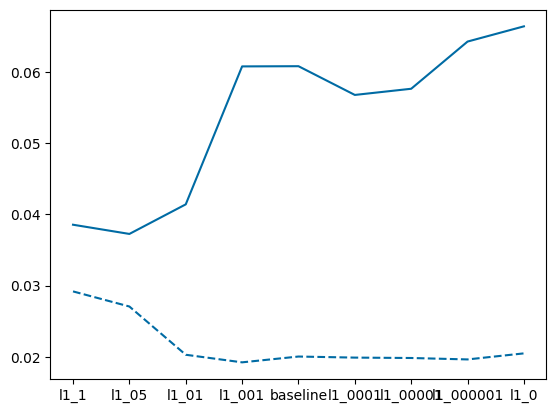

In [36]:
df = ma.coverage_stats().loc[:, 'place']
ax = df.loc[('trn', 'sizes')].T.plot()
ax.set_prop_cycle(None)
df.loc[('unt', 'sizes')].T.plot(ax=ax, linestyle='--')
plt.show()

### Hidden Unit Regularization

In [37]:
hps = [f'hp_{n}' for n in ['05', '01', '005', '0005', '0001', '0']]
hps.insert(3, 'baseline')

ma = MultiAnalysis(data_path, hps)

In [38]:
var = ['proportion']
units = ['place']
how = 'trn'

data = ma.get_data_for_statistical_test(var, units, how)

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=28.624169014084526, pvalue=7.165189693969824e-05)}

In [39]:
units = ['active']

data = ma.get_data_for_statistical_test(var, units, how)

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=32.48516746411486, pvalue=1.316947664174e-05)}

In [40]:
how='unt'

data = ma.get_data_for_statistical_test(var, units, how)

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=127.38608521999947, pvalue=4.5630158194690255e-25)}

In [41]:
var = ['remapping', 'turnover']
units = ['place']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how, hps[:-1])

{v: kruskal(*data) for v, data in data.items()}

{'remapping': KruskalResult(statistic=4.981325593803507, pvalue=0.4181634932525504),
 'turnover': KruskalResult(statistic=13.637970307345046, pvalue=0.018080215289264425)}

In [42]:
var = ['turnover']
units = ['active']

data = ma.get_data_for_statistical_test(var, units, how, hps[:-2])
data['turnover'][1] = np.nan_to_num(data['turnover'][1], 0)

{v: kruskal(*data) for v, data in data.items()}

{'turnover': KruskalResult(statistic=28.826732700005397, pvalue=8.477192193688873e-06)}

In [43]:
var = ['proportion']
units = ['place']
how = 'trn'

data = ma.get_data_for_statistical_test(var, units, how, hps[:-1])

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=21.817684021543997, pvalue=0.0005670701745801759)}

In [44]:
var = ['proportion']
units = ['place']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how, hps[:-2])

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=60.82529101770472, pvalue=1.9456306032471456e-12)}

#### Coverage

In [45]:
var = ['coverage', 'sizes', 'scales']
units = ['place']
how = 'trn'

data = ma.get_data_for_statistical_test(var, units, how, hps[:-2])

{v: kruskal(*data) for v, data in data.items()}

{'coverage': KruskalResult(statistic=7.579530588687953, pvalue=0.10825303416929885),
 'sizes': KruskalResult(statistic=14.754461538461541, pvalue=0.005238535175017048),
 'scales': KruskalResult(statistic=20.37415384615386, pvalue=0.0004212358543149809)}

In [46]:
var = ['coverage', 'sizes', 'scales']
units = ['place']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how, hps[:-1])

{v: kruskal(*data) for v, data in data.items()}

{'coverage': KruskalResult(statistic=30.345950413223136, pvalue=1.2607234250744832e-05),
 'sizes': KruskalResult(statistic=75.08553719008262, pvalue=8.928317645216199e-15),
 'scales': KruskalResult(statistic=93.54975206611567, pvalue=1.2054895984487303e-18)}

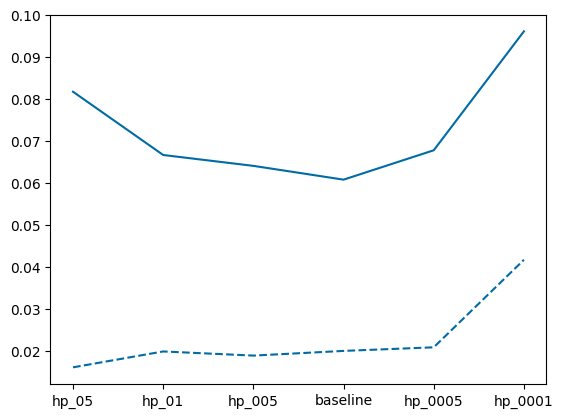

In [47]:
df = ma.coverage_stats().loc[:, 'place'][hps[:-1]]
ax = df.loc[('trn', 'sizes')].T.plot()
ax.set_prop_cycle(None)
df.loc[('unt', 'sizes')].T.plot(ax=ax, linestyle='--')
plt.show()

### Number of Modules

In [48]:
modules = ['1modules1024cells_homo', '2modules484cells', '3modules324cells', '5modules196cells', 'baseline']

ma = MultiAnalysis(data_path, modules)

In [49]:
var = ['proportion']
units = ['place']
how = 'trn'

data = ma.get_data_for_statistical_test(var, units, how, modules[1:])

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=0.24506828528072572, pvalue=0.9700053156461638)}

In [50]:
units = ['active']

data = ma.get_data_for_statistical_test(var, units, how, modules[1:])

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=4.6467075038284955, pvalue=0.19957170315491934)}

In [51]:
units = ['place']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how, modules[1:])

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=38.357923073306004, pvalue=2.3738855504029786e-08)}

In [52]:
units = ['active']

data = ma.get_data_for_statistical_test(var, units, how, modules[1:])

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=11.541070798334196, pvalue=0.009132597423752711)}

In [53]:
var = ['remapping', 'turnover']
units = ['place']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how, modules[2:])
# data['remapping'][0] = np.nan_to_num(data['remapping'][0])

{v: kruskal(*data) for v, data in data.items()}

{'remapping': KruskalResult(statistic=0.09336479733480896, pvalue=0.9543904651440404),
 'turnover': KruskalResult(statistic=0.7857319547513827, pvalue=0.675119222773094)}

In [54]:
var = ['turnover']
units = ['active']

data = ma.get_data_for_statistical_test(var, units, how, modules[1:])

{v: kruskal(*data) for v, data in data.items()}

{'turnover': KruskalResult(statistic=24.52000093796531, pvalue=1.94530068296614e-05)}

In [55]:
var = ['coverage', 'sizes', 'scales']
units = ['place']
how = 'trn'

data = ma.get_data_for_statistical_test(var, units, how, modules[1:])

{v: kruskal(*data) for v, data in data.items()}

{'coverage': KruskalResult(statistic=7.594268476621416, pvalue=0.05518512783009921),
 'sizes': KruskalResult(statistic=10.474285714285728, pvalue=0.014936350378810324),
 'scales': KruskalResult(statistic=0.9199999999999946, pvalue=0.8205988623005116)}

In [56]:
var = ['coverage', 'sizes', 'scales']
units = ['place']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how, modules[1:])

{v: kruskal(*data) for v, data in data.items()}

{'coverage': KruskalResult(statistic=14.685370370370379, pvalue=0.0021062520392731363),
 'sizes': KruskalResult(statistic=3.4172222222222217, pvalue=0.33165787547063497),
 'scales': KruskalResult(statistic=4.28129629629629, pvalue=0.2326475770848244)}

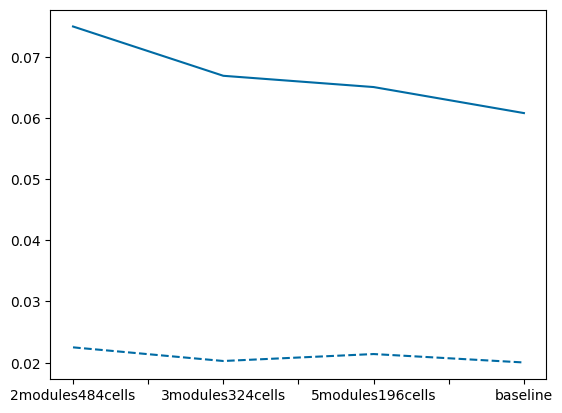

In [57]:
df = ma.coverage_stats().loc[:, 'place'][modules[1:]]
ax = df.loc[('trn', 'sizes')].T.plot()
ax.set_prop_cycle(None)
df.loc[('unt', 'sizes')].T.plot(ax=ax, linestyle='--')
plt.show()

### Number of Cells

In [58]:
cells = ['25cells', '49cells', 'baseline', '169cells']

ma = MultiAnalysis(data_path, cells)

In [59]:
var = ['proportion']
units = ['place']
how = 'trn'

data = ma.get_data_for_statistical_test(var, units, how)

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=5.1917933130699145, pvalue=0.15827988602903578)}

In [60]:
units = ['active']

data = ma.get_data_for_statistical_test(var, units, how)

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=15.564226415094344, pvalue=0.0013927803706398462)}

In [61]:
units = ['place']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how)

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=37.9526289822385, pvalue=2.8925042107307897e-08)}

In [62]:
units = ['active']

data = ma.get_data_for_statistical_test(var, units, how)

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=38.77456766563001, pvalue=1.937400348060526e-08)}

In [63]:
var = ['remapping', 'turnover']
units = ['place']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how)

{v: kruskal(*data) for v, data in data.items()}

{'remapping': KruskalResult(statistic=7.775273210831744, pvalue=0.050891782731573),
 'turnover': KruskalResult(statistic=34.35021157633159, pvalue=1.6710265548288904e-07)}

In [65]:
var = ['turnover']
units = ['active']

data = ma.get_data_for_statistical_test(var, units, how)

{v: kruskal(*data) for v, data in data.items()}

{'turnover': KruskalResult(statistic=49.82909857206502, pvalue=8.687555475391704e-11)}

In [66]:
var = ['coverage', 'sizes', 'scales']
units = ['place']
how = 'trn'

data = ma.get_data_for_statistical_test(var, units, how)

{v: kruskal(*data) for v, data in data.items()}

{'coverage': KruskalResult(statistic=6.234285714285704, pvalue=0.10075172198601619),
 'sizes': KruskalResult(statistic=11.228571428571428, pvalue=0.010551983436600625),
 'scales': KruskalResult(statistic=10.760000000000005, pvalue=0.013097023231777093)}

In [67]:
var = ['coverage', 'sizes', 'scales']
units = ['place']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how)

{v: kruskal(*data) for v, data in data.items()}

{'coverage': KruskalResult(statistic=4.772592592592616, pvalue=0.18922673464133785),
 'sizes': KruskalResult(statistic=7.131666666666689, pvalue=0.06781743540897564),
 'scales': KruskalResult(statistic=68.94407407407414, pvalue=7.18357517104875e-15)}

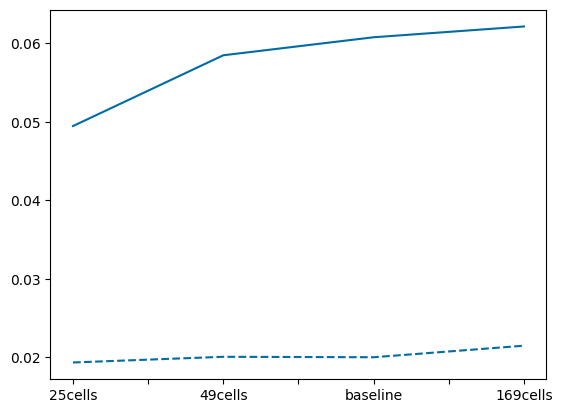

In [68]:
df = ma.coverage_stats().loc[:, 'place']
ax = df.loc[('trn', 'sizes')].T.plot()
ax.set_prop_cycle(None)
df.loc[('unt', 'sizes')].T.plot(ax=ax, linestyle='--')
plt.show()

### Homogeneous Peaks

In [69]:
conds = ['homo', 'baseline']
ma = MultiAnalysis(data_path, conds)

In [70]:
ma.get_confidence_intervals()

active             place
homo     trn coverage       1.00$\pm$0.00     0.72$\pm$0.02
             proportion     0.62$\pm$0.06     0.46$\pm$0.08
             scales           nan$\pm$nan     0.50$\pm$0.04
             sizes            nan$\pm$nan     0.03$\pm$0.02
         unt IoU            0.99$\pm$0.01     0.56$\pm$0.08
             coverage       1.00$\pm$0.00     0.51$\pm$0.06
             intersection  78.70$\pm$7.05    45.75$\pm$7.69
             proportion     0.62$\pm$0.05     0.37$\pm$0.05
             remapping        nan$\pm$nan     0.98$\pm$0.02
             scales           nan$\pm$nan     0.52$\pm$0.11
             sizes            nan$\pm$nan  0.02$\pm$1.5e-03
             turnover       0.02$\pm$0.02     0.64$\pm$0.12
             union         79.65$\pm$6.70    81.10$\pm$5.08
baseline trn coverage       1.00$\pm$0.00     0.98$\pm$0.02
             proportion     0.59$\pm$0.02     0.54$\pm$0.05
             scales           nan$\pm$nan     0.25$\pm$0.03
             sizes            nan$\pm$nan  0.06$\pm$3.8e-03
         unt IoU            0.76$\pm$0.02     0.41$\pm$0.06
             coverage       1.00$\pm$0.00     0.63$\pm$0.08
             intersection  70.65$\pm$1.95    37.05$\pm$5.32
             proportion     0.69$\pm$0.03     0.41$\pm$0.05
             remapping        nan$\pm$nan     0.98$\pm$0.03
             scales           nan$\pm$nan     0.16$\pm$0.03
             sizes            nan$\pm$nan  0.02$\pm$2.4e-03
             turnover       0.39$\pm$0.05     0.85$\pm$0.10
             union         93.45$\pm$2.93    90.75$\pm$3.99

In [71]:
var = ['proportion', 'scales', 'coverage', 'sizes']
units = ['place']
how = 'trn'

data = ma.get_data_for_statistical_test(var, units, how)

{v: ranksums(*data) for v, data in data.items()}

{'proportion': RanksumsResult(statistic=1.5666989036012806, pvalue=0.11718508719813801),
 'scales': RanksumsResult(statistic=-2.6111648393354674, pvalue=0.009023438818080326),
 'coverage': RanksumsResult(statistic=2.6111648393354674, pvalue=0.009023438818080326),
 'sizes': RanksumsResult(statistic=2.40227165218863, pvalue=0.016293603621028527)}

In [72]:
var = ['proportion']
units = ['active']
how = 'trn'

data = ma.get_data_for_statistical_test(var, units, how)

{v: ranksums(*data) for v, data in data.items()}

{'proportion': RanksumsResult(statistic=-1.5666989036012806, pvalue=0.11718508719813801)}

In [73]:
var = ['proportion', 'scales', 'coverage', 'sizes', 'remapping', 'turnover']
units = ['place']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how)

{v: ranksums(*data) for v, data in data.items()}

{'proportion': RanksumsResult(statistic=2.204582256761872, pvalue=0.027483421975621553),
 'scales': RanksumsResult(statistic=-5.410017808004594, pvalue=6.301848221392269e-08),
 'coverage': RanksumsResult(statistic=4.517364869683836, pvalue=6.2613960558707055e-06),
 'sizes': RanksumsResult(statistic=4.787865760084065, pvalue=1.6856433537154655e-06),
 'remapping': RanksumsResult(statistic=-0.5410017808004594, pvalue=0.5885063552717107),
 'turnover': RanksumsResult(statistic=4.92311620528418, pvalue=8.517683792974374e-07)}

In [74]:
var = ['proportion', 'turnover']
units = ['active']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how)

{v: ranksums(*data) for v, data in data.items()}

{'proportion': RanksumsResult(statistic=5.085416739524318, pvalue=3.6681972655029196e-07),
 'turnover': RanksumsResult(statistic=5.410017808004594, pvalue=6.301848221392269e-08)}

### Env 2 training

In [2]:
exp_names = ['2fits50b', '2fits500b', '2fits5000b', '2fits']
batches = [50, 500, 5000, 50000]

In [3]:
ma = MultiAnalysis2Fits(data_path, exp_names)

In [4]:
kruskal(*ma.anls[-1].evals[:, 1][:,-4:].T)

KruskalResult(statistic=16.074285714285708, pvalue=0.0010949020632170217)

In [5]:
var = ['remapping']
units = ['place']

data = ma.get_data_for_statistical_test(var, units, 'trn', which=2, subset=['2fits'])[var[0]]
data.append(ma.get_data_for_statistical_test(var, units, 'unt', which=1, subset=['2fits'])[var[0]][0])

kruskal(*data)

KruskalResult(statistic=6.818181818181813, pvalue=0.009023438818080334)

In [6]:
var = ['turnover']
units = ['place']

data = ma.get_data_for_statistical_test(var, units, 'trn', which=2, subset=['2fits'])[var[0]]
data.append(ma.get_data_for_statistical_test(var, units, 'unt', which=1, subset=['2fits'])[var[0]][0])

kruskal(*data)

KruskalResult(statistic=6.818181818181813, pvalue=0.009023438818080334)

In [7]:
var = ['turnover']
units = ['active']

data = ma.get_data_for_statistical_test(var, units, 'trn', which=2, subset=['2fits'])[var[0]]
data.append(ma.get_data_for_statistical_test(var, units, 'unt', which=1, subset=['2fits'])[var[0]][0])

kruskal(*data)

KruskalResult(statistic=6.818181818181813, pvalue=0.009023438818080334)

In [8]:
var = ['proportion']
units = ['place']
how = 'trn'

data = ma.get_data_for_statistical_test(var, units, how, 2)

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=13.59848942598187, pvalue=0.003505892524598698)}

In [9]:
var = ['proportion']
units = ['active']
how = 'trn'

data = ma.get_data_for_statistical_test(var, units, how, 2)

{v: kruskal(*data) for v, data in data.items()}

{'proportion': KruskalResult(statistic=16.141415662650598, pvalue=0.0010607365759832943)}

In [10]:
var = ['coverage']
units = ['place']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how, 2)

{v: kruskal(*data) for v, data in data.items()}

{'coverage': KruskalResult(statistic=13.822857142857131, pvalue=0.00315646409496273)}

In [11]:
var = ['coverage']
units = ['place']
how = 'trn'

data = ma.get_data_for_statistical_test(var, units, how, 2)

{v: kruskal(*data) for v, data in data.items()}

{'coverage': KruskalResult(statistic=13.853092006033174, pvalue=0.003112095073100279)}

In [12]:
var = ['scales', 'sizes']
units = ['place']
how = 'trn'

data = ma.get_data_for_statistical_test(var, units, how, 2)

{v: kruskal(*data) for v, data in data.items()}

{'scales': KruskalResult(statistic=10.748571428571424, pvalue=0.013166115556046663),
 'sizes': KruskalResult(statistic=14.200000000000003, pvalue=0.002645179989245594)}

In [13]:
var = ['scales', 'sizes']
units = ['place']
how = 'unt'

data = ma.get_data_for_statistical_test(var, units, how, 2)

{v: kruskal(*data) for v, data in data.items()}

{'scales': KruskalResult(statistic=11.159999999999997, pvalue=0.010891421468579314),
 'sizes': KruskalResult(statistic=16.89714285714284, pvalue=0.000742013377741852)}

In [14]:
var = ['sizes']
units = ['place']
how = 'both'

data = ma.get_data_for_statistical_test(var, units, how, 2, ['2fits'])

{v: kruskal(*data) for v, data in data.items()}

{'sizes': KruskalResult(statistic=0.010909090909095198, pvalue=0.9168149485280722)}

In [15]:
df = MultiAnalysis2Fits.get_retrain_remaps(data_path, exp_names)
df = df.loc[(slice(None), slice(None), 'remappping'), "1_1'"]
kruskal(*[x.values for _, x in  df.groupby(level=0)])

KruskalResult(statistic=17.102857142857133, pvalue=0.0006731379787971982)

In [16]:
df = MultiAnalysis2Fits.get_retrain_remaps(data_path, exp_names)
df = df.loc[(slice(None), slice(None), 'turnover_pc'), "1_1'"]
kruskal(*[x.values for _, x in  df.groupby(level=0)])

KruskalResult(statistic=16.58961625282166, pvalue=0.0008582413824039257)

In [17]:
df = MultiAnalysis2Fits.get_retrain_remaps(data_path, exp_names)
df = df.loc[(slice(None), slice(None), 'turnover_ac'), "1_1'"]
kruskal(*[x.values for _, x in  df.groupby(level=0)])

KruskalResult(statistic=17.331428571428575, pvalue=0.0006040399658588237)

In [18]:
df = MultiAnalysis2Fits.get_retrain_remaps(data_path, exp_names)
df = df.loc[(slice(None), slice(None), 'remappping'), "2_2'"]
kruskal(*[x.values for _, x in  df.groupby(level=0)])

KruskalResult(statistic=16.897142857142853, pvalue=0.0007420133777418467)

In [19]:
df = MultiAnalysis2Fits.get_retrain_remaps(data_path, exp_names)
df = df.loc[(slice(None), slice(None), 'turnover_pc'), "2_2'"]
kruskal(*[x.values for _, x in  df.groupby(level=0)])

KruskalResult(statistic=16.714285714285708, pvalue=0.000809089618167436)

In [20]:
df = MultiAnalysis2Fits.get_retrain_remaps(data_path, exp_names)
df = df.loc[(slice(None), slice(None), 'turnover_ac'), "2_2'"]
kruskal(*[x.values for _, x in  df.groupby(level=0)])

KruskalResult(statistic=16.554285714285697, pvalue=0.0008727023933484354)

In [21]:
df = MultiAnalysis2Fits.get_retrain_remaps(data_path, exp_names)
df = df.loc[('2fits', slice(None), 'turnover_ac')]
kruskal(*[df[c] for c in df.columns])

KruskalResult(statistic=6.818181818181813, pvalue=0.009023438818080334)